In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
in_dir = Path('/Users/rdcrlzh1/Documents/spicy-analysis/data/SnowEx-Data')
# in_dir = Path('~/spicy-snow/SnowEx-Data-Hans/').expanduser().resolve()

dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

snotel = pd.read_csv('/Users/rdcrlzh1/Documents/spicy-analysis/data/snotel/snotel.csv', comment = '#', parse_dates=['Date'], index_col='Date')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 25, saw 2


In [8]:
snotel_names = {'Banner': 'Banner Summit (312)', 'Dry Creek': 'Bogus Basin (978)', 'Little Cottonwood': 'Snowbird (766)', 'Mores': 'Mores Creek Summit (637)', 'Cameron': 'Joe Wright (551)', 'Fraser': 'Fool Creek (1186)'}
snotels = pd.DataFrame()
for stem, ds in dss.items():
    site = ' '.join(stem.split('_')[:-1]).replace('Frasier', 'Fraser')
    snotel_name = snotel_names[site]
    snotels.loc[' '.join(stem.split('-')[0].split('_')[:-1]), 'id'] = snotel_name
snotels

/var/folders/hn/hd92_2tj7rj8xghqt1qf0nhr2p1n49/T/ipykernel_76294/1781472559.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Mores Creek Summit (637)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  snotels.loc[' '.join(stem.split('-')[0].split('_')[:-1]), 'id'] = snotel_name


,id
Mores,Mores Creek Summit (637)
Frasier,Fool Creek (1186)
Dry Creek,Bogus Basin (978)
Banner,Banner Summit (312)
Cameron,Joe Wright (551)
Little Cottonwood,Snowbird (766)


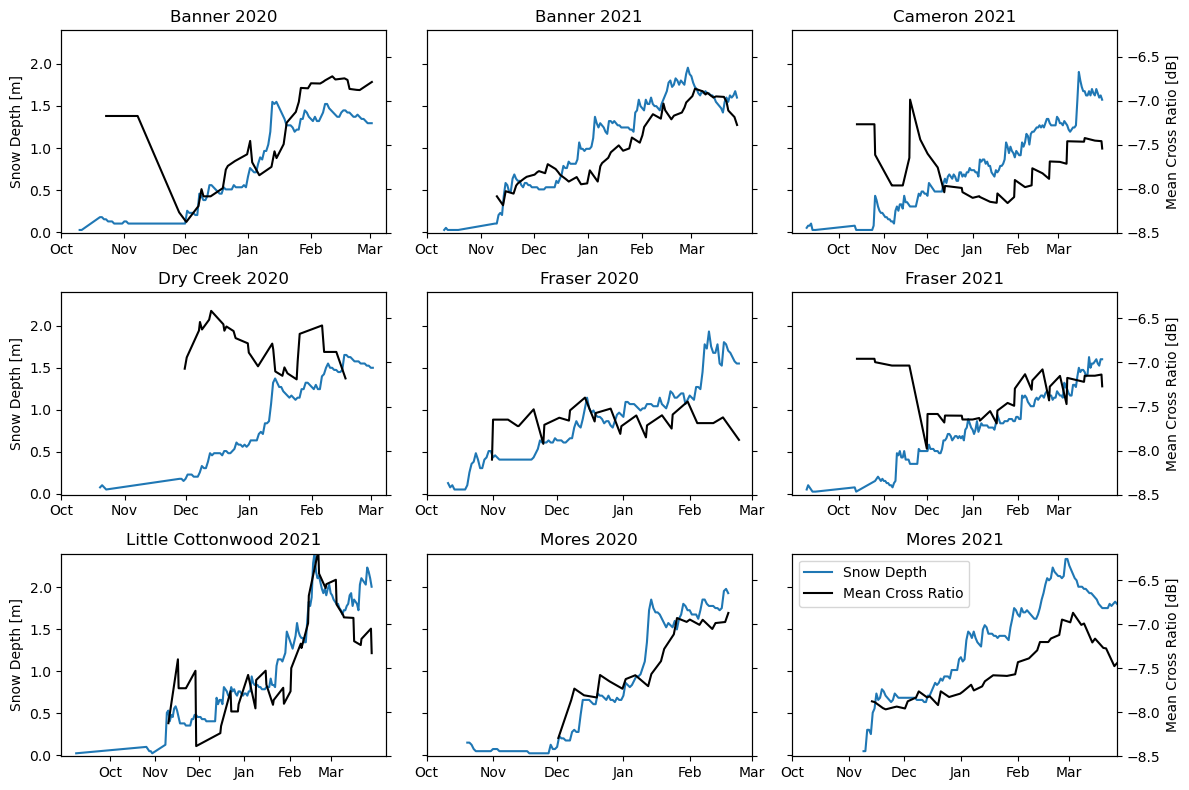

In [71]:
import re
import matplotlib.dates as mdates

snotel_names = {'Banner': 'Banner Summit (312)', 'Dry Creek': 'Bogus Basin (978)', 'Little Cottonwood': 'Snowbird (766)', 'Mores': 'Mores Creek Summit (637)', 'Cameron': 'Joe Wright (551)', 'Fraser': 'Fool Creek (1186)'}
fig, axes = plt.subplots(3, 3, figsize = (12, 8))
for i, (ax, (stem, ds)) in enumerate(zip(axes.ravel(), sorted(dss.items()))):
    site = ' '.join(stem.split('_')[:-1]).replace('Frasier', 'Fraser')
    snotel_name = snotel_names[site]
    d_min, d_max = ds.time.dt.date.min().values.ravel()[0], ds.time.dt.date.max().values.ravel()[0]

    sub = snotel.loc[d_min:d_max, snotel.columns.str.contains(re.escape(snotel_name))].copy()
    sub.loc[:, 'sd'] = sub.loc[:, f'{snotel_name} Snow Depth (in) Start of Day Values'] * 0.0254
    sub = sub.loc[sub.sd>0, :]
    sub.sd.plot(ax = ax)

    ax_s1 = ax.twinx()
    ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
    ds['CR'].where(ds['ims'].mean(['x','y']) == 4).mean(['x', 'y']).rolling(time = 5, min_periods = 1).mean().dropna('time').plot(ax = ax_s1, color = 'black')

    ax_s1.set_title('')
    ax.set_title(stem.split('-')[0].replace('_', ' ').replace('Frasier', 'Fraser'))

    # formatter = mdates.DateFormatter('%b')
    # ax.xaxis.set_major_formatter(formatter)
    year = int(stem.split('-')[0].split('_')[-1])

    ax.set_xticks(pd.date_range(f'{year-1}-10-01', f'{year}-03-01', freq='MS'))
    ax.set_xticklabels(pd.date_range(f'{year-1}-10-01', f'{year}-03-01', freq='MS').strftime('%b'), rotation=0, fontdict={'horizontalalignment':'center'})
    ax.tick_params(axis='x', which='minor', bottom=False)

    # ax_s1.set_xlabel('')
    ax.set_xlabel('')
    if i % 3 != 2: 
        ax_s1.set_ylabel('')
        ax_s1.set_yticklabels([])
    else:
        ax_s1.set_ylabel('Mean Cross Ratio [dB]')
    if i %3 != 0: ax.set_yticklabels([])
    ax_s1.set_ylim(-8.5, -6.2)
    ax.set_ylim(-0.01, 2.4)

for ax in axes[:, 0]: ax.set_ylabel('Snow Depth [m]')

plt.gca().plot([],[], color=plt.get_cmap('tab10')(0), label = 'Snow Depth')
plt.gca().plot([],[], color = 'black', label = 'Mean Cross Ratio')
plt.gca().legend(loc = 'upper left')

plt.tight_layout()

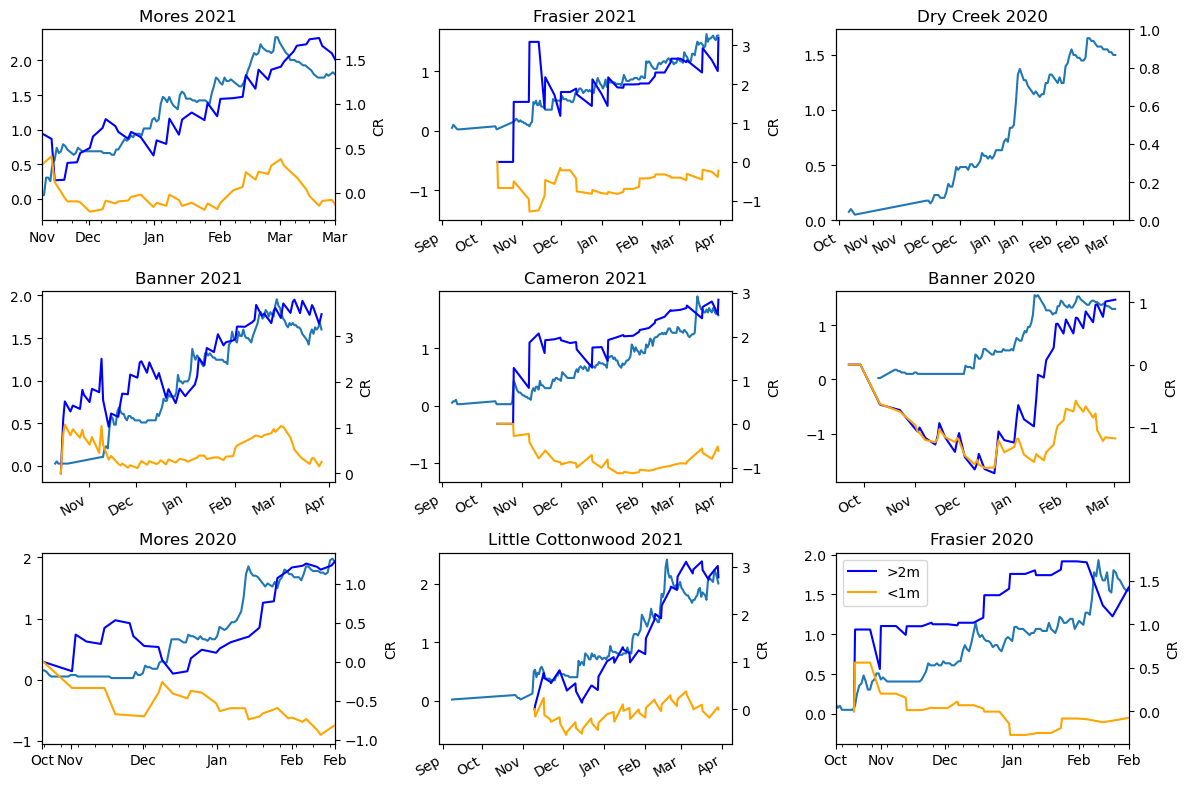

In [6]:
import re
import matplotlib.dates as mdates


snotel_names = {'Banner': 'Banner Summit (312)', 'Dry Creek': 'Bogus Basin (978)', 'Little Cottonwood': 'Snowbird (766)', 'Mores': 'Mores Creek Summit (637)', 'Cameron': 'Joe Wright (551)', 'Frasier': 'Fool Creek (1186)'}
fig, axes = plt.subplots(3, 3, figsize = (12, 8))
for ax, (stem, ds) in zip(axes.ravel(), dss.items()):
    site = ' '.join(stem.split('_')[:-1])
    snotel_name = snotel_names[site]
    d_min, d_max = ds.time.dt.date.min().values.ravel()[0], ds.time.dt.date.max().values.ravel()[0]

    sub = snotel.loc[d_min:d_max, snotel.columns.str.contains(re.escape(snotel_name))].copy()
    sub.loc[:, 'sd'] = sub.loc[:, f'{snotel_name} Snow Depth (in) Start of Day Values'] * 0.0254
    sub = sub.loc[sub.sd>0, :]
    sub.sd.plot(ax = ax)

    ax_s1 = ax.twinx()
    ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
    try:
        lsd = ds['CR'].where(ds['lidar-sd'] > 2).where(ds['ims'] == 4).mean(['x', 'y']).rolling(time = 6, min_periods = 1).mean().dropna('time')
        (lsd - lsd.isel(time = 0)).plot(ax = ax_s1, color = 'blue', label = '>2m')
        hsd = ds['CR'].where(ds['lidar-sd'] < 1).where(ds['ims'] == 4).mean(['x', 'y']).rolling(time = 6, min_periods = 1).mean().dropna('time')
        (hsd - hsd.isel(time = 0)).plot(ax = ax_s1, color = 'orange', label = '<1m')
    except:
        pass

    ax.set_ylim(bottom = ax_s1.get_ylim()[0])
    ax_s1.set_title('')
    ax.set_title(stem.split('-')[0].replace('_', ' '))
    
    ax.set_xlabel('')
    # formatter = pd.plotting._matplotlib.converter.TimeSeries_DateFormatter('D')
    formatter = mdates.DateFormatter('%b')
    # locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    # formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_formatter(formatter)
    # formatter = mdates.DateFormatter('%y')
    # ax.xaxis.set_minor_formatter(formatter)
    # print(formatter.plot_obj)
    # print(formatter.locs)
    # df = ax.xaxis.get_major_formatter()
    # if ax != axes.ravel()[0]: ax.xaxis.set_major_formatter(formatter)
    # else: formatter = df
    # print(df)

ax_s1.legend()
plt.tight_layout()

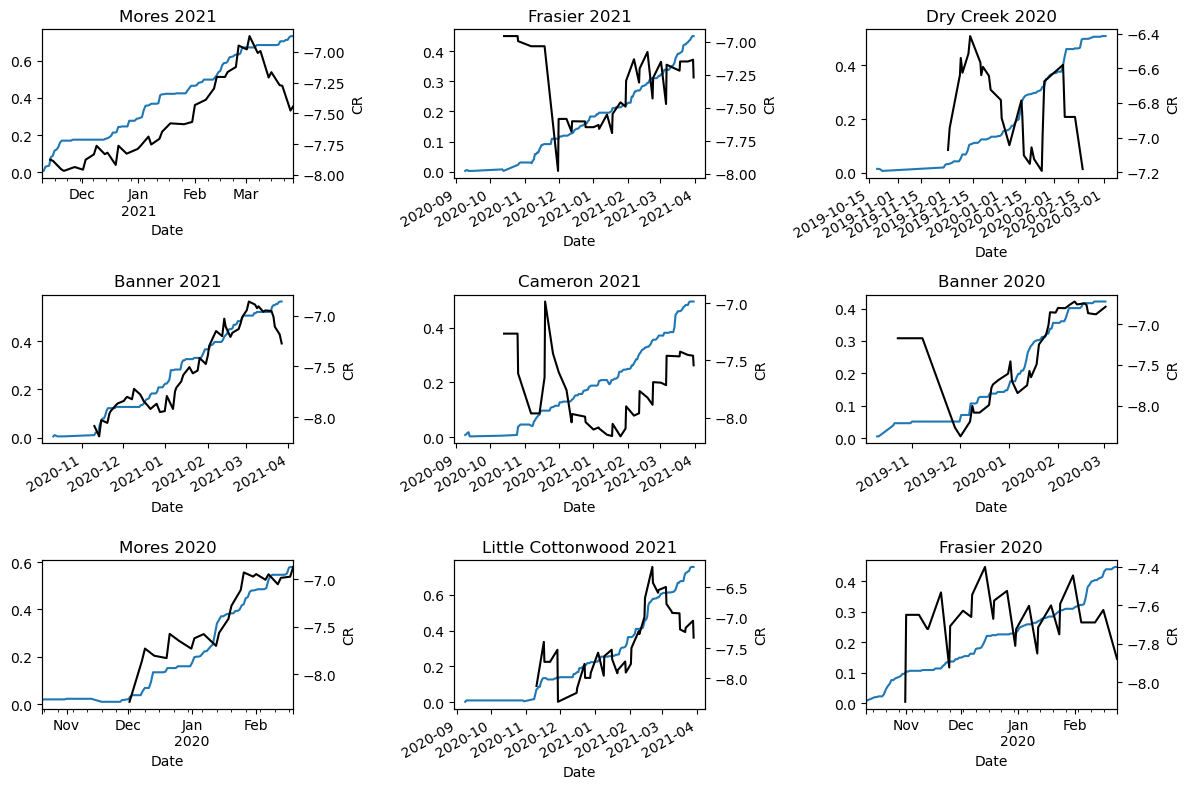

In [78]:
# fig, axes = plt.subplots(3, 3, figsize = (12, 8))
# csv_dir = Path('/Users/rdcrlzh1/Documents/spicy-analysis/data/snotel')
# for ax, (stem, ds) in zip(axes.ravel(), dss.items()):
#     df = pd.read_csv(csv_dir.joinpath('_'.join(stem.split('_')[:-1])).with_suffix('.csv'), comment = '#', parse_dates=['Date'], index_col = 'Date')
#     d_min, d_max = ds.time.dt.date.min().values.ravel()[0], ds.time.dt.date.max().values.ravel()[0]
#     df_year = df.loc[d_min:d_max].copy()
    
#     df_year.loc[:, 'swe'] = df_year.loc[:,'Snow Water Equivalent (in) Start of Day Values'] *0.0254
#     df_year = df_year.loc[df_year.swe > 0]
#     df_year['swe'].plot(ax = ax)

#     ax_s1 = ax.twinx()

#     ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
#     ds['CR'].where(ds['ims'].mean(['x','y']) == 4).mean(['x', 'y']).rolling(time = 5, min_periods = 1).mean().dropna('time').plot(ax = ax_s1, color = 'black')
#     ax_s1.set_title('')
#     ax.set_title(stem.split('-')[0].replace('_', ' '))

# plt.tight_layout()

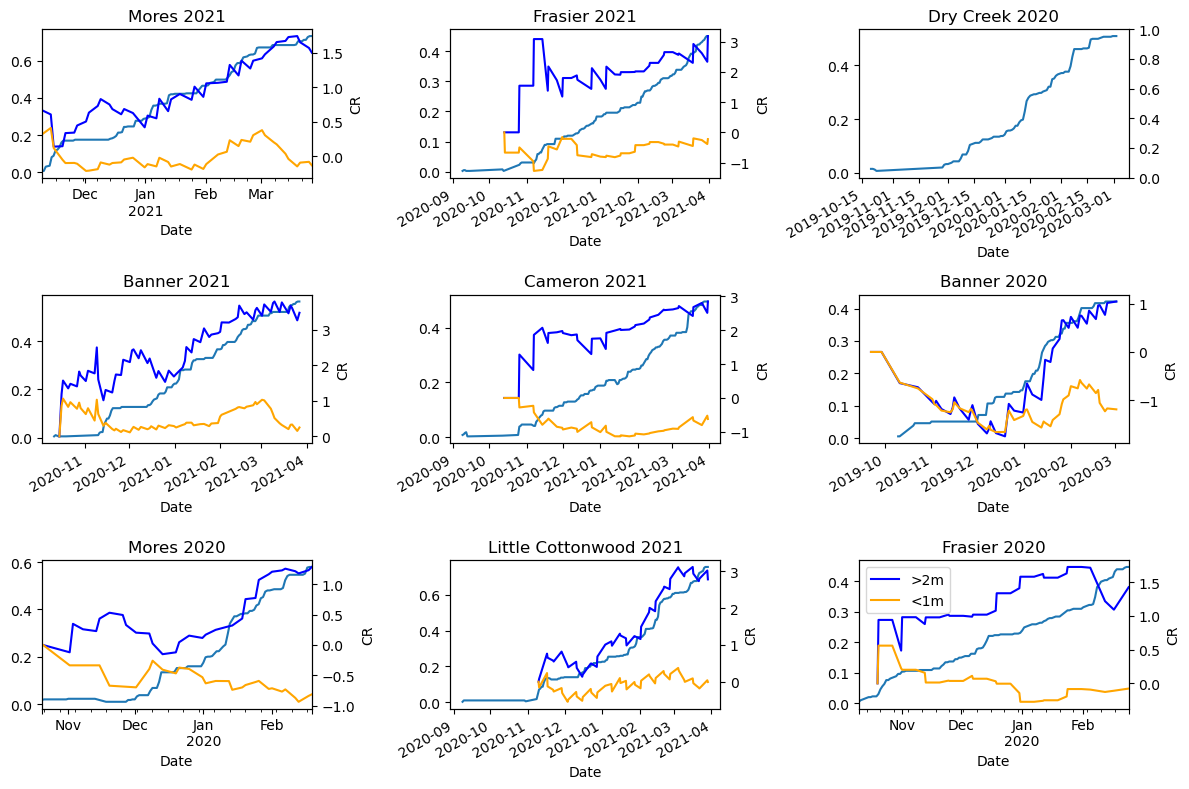

In [100]:
# fig, axes = plt.subplots(3, 3, figsize = (12, 8))
# csv_dir = Path('/Users/rdcrlzh1/Documents/spicy-analysis/data/snotel')
# for ax, (stem, ds) in zip(axes.ravel(), dss.items()):
#     df = pd.read_csv(csv_dir.joinpath('_'.join(stem.split('_')[:-1])).with_suffix('.csv'), comment = '#', parse_dates=['Date'], index_col = 'Date')
#     d_min, d_max = ds.time.dt.date.min().values.ravel()[0], ds.time.dt.date.max().values.ravel()[0]
#     df_year = df.loc[d_min:d_max].copy()
    
#     df_year.loc[:, 'swe'] = df_year.loc[:,'Snow Water Equivalent (in) Start of Day Values'] *0.0254
#     df_year = df_year.loc[df_year.swe > 0]
#     df_year['swe'].plot(ax = ax)

#     ax_s1 = ax.twinx()

#     ds['CR'] = ds['s1'].sel(band = 'VH') - ds['s1'].sel(band = 'VV')
#     try:
#         lsd = ds['CR'].where(ds['lidar-sd'] > 2).where(ds['ims'] == 4).mean(['x', 'y']).rolling(time = 6, min_periods = 1).mean().dropna('time')
#         (lsd - lsd.isel(time = 0)).plot(ax = ax_s1, color = 'blue', label = '>2m')
#         hsd = ds['CR'].where(ds['lidar-sd'] < 1).where(ds['ims'] == 4).mean(['x', 'y']).rolling(time = 6, min_periods = 1).mean().dropna('time')
#         (hsd - hsd.isel(time = 0)).plot(ax = ax_s1, color = 'orange', label = '<1m')
#     except:
#         pass
#     ax_s1.set_title('')
#     ax.set_title(stem.split('-')[0].replace('_', ' '))
# ax_s1.legend()
# plt.tight_layout()